In [17]:
%pip install matplotlib
%pip install cmcrameri
# pongo esto dado que el environment.yml no contaba con estos paquetes

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
%%file gridding_tomasLopez_angelAvendaño.py

from mpi4py import MPI
import numpy as np
import sys

# Sistemas Distribuidos USACH 2023-2
# Profesor: Dr. Miguel Cárcamo
# Integrantes: Tomás López, Angel Avendaño

# Function to transform coordinates u and v to wavelengths
def transform_coordinates(data):
    c = 299792458.0  # Speed of light in meters per second
    data[:,0] = data[:,0]*data[:,6]/c
    data[:,1] = data[:,1]*data[:,6]/c
    return data

# Function to perform the gridding process
def grid_data(local_data, N, delta_x_rad):
    local_F_r = np.zeros((N, N))
    local_F_i = np.zeros((N, N))
    local_W_t = np.zeros((N, N))
    
    delta_u_lambda = 1/(delta_x_rad*N)

    i = np.clip(np.round(local_data[:,0]/delta_u_lambda + N/2).astype(int), 0, N-1)
    
    j = np.clip(np.round(local_data[:,1]/delta_u_lambda + N/2).astype(int), 0, N-1)
    
    np.add.at(local_F_r, (i, j), local_data[:,3] * local_data[:,5])
    np.add.at(local_F_i, (i, j), local_data[:,4] * local_data[:,5])
    np.add.at(local_W_t, (i, j), local_data[:,5])
    
    return local_F_r, local_F_i, local_W_t

# Parse command-line arguments
if len(sys.argv) != 7:
    print("Usage: mpirun -n num_processes python gridding.py -i data_file -d deltax -N image_size")
    sys.exit(1)

if sys.argv[1] != '-i':
    print("Error: You must specify the data file using -i")
    sys.exit(1)

if sys.argv[3] != '-d':
    print("Error: You must specify the value of deltax using -d")
    sys.exit(1)

if sys.argv[5] != '-N':
    print("Error: You must specify the image size using -N")
    sys.exit(1)

input_file = sys.argv[2]
name_file = "./"+sys.argv[2]
delta_x_arcsec = float(sys.argv[4])
delta_x_rad = (np.pi/(180*3600))*delta_x_arcsec
N = int(sys.argv[6])


# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

sendbuf = None
data_per_process = None
if rank == 0:
    sendbuf = np.loadtxt(name_file, delimiter=",")
    transform_coordinates(sendbuf)
    data_per_process = len(sendbuf) // size

# Broadcast the number of rows per process
data_per_process = comm.bcast(data_per_process, root=0)

# Scatter Process
recvbuf = np.empty([data_per_process, 8], dtype=np.float64)
comm.Scatter(sendbuf, recvbuf, root=0)

# Gridding Process
local_F_r, local_F_i, local_W_t = grid_data(recvbuf, N, delta_x_rad)

# Gather Process
gathered_F_r = np.zeros((size, N, N)) if rank == 0 else None
gathered_F_i = np.zeros((size, N, N)) if rank == 0 else None
gathered_W_t = np.zeros((size, N, N)) if rank == 0 else None

comm.Gather(local_F_r, gathered_F_r, root=0)
comm.Gather(local_F_i, gathered_F_i, root=0)
comm.Gather(local_W_t, gathered_W_t, root=0)

# Join partial results
if rank == 0:
    F_r_total = np.sum(gathered_F_r, axis=0)
    F_i_total = np.sum(gathered_F_i, axis=0)
    W_t_total = np.sum(gathered_W_t, axis=0)
    
    # Normalization
    # Avoid division by zero
    W_t_total[W_t_total == 0] = 1
    F_r_total /= W_t_total
    F_i_total /= W_t_total
    
    # Construct the complex grid and perform the inverse FFT
    grid = F_r_total + 1j * F_i_total
    dirty_image = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(grid)))
    
    # Guardar el grid en un archivo .npy
    np.save('grid.npy', grid)
    # Guardar la imagen sucia en un archivo .npy
    np.save('dirty_image.npy', dirty_image)
    
# Finalize MPI
MPI.Finalize()

Overwriting gridding_tomasLopez_angelAvendaño.py


In [19]:
!mpirun -n 8 python gridding_tomasLopez_angelAvendaño.py -i hltau_completo_uv.csv -d 0.003 -N 2048

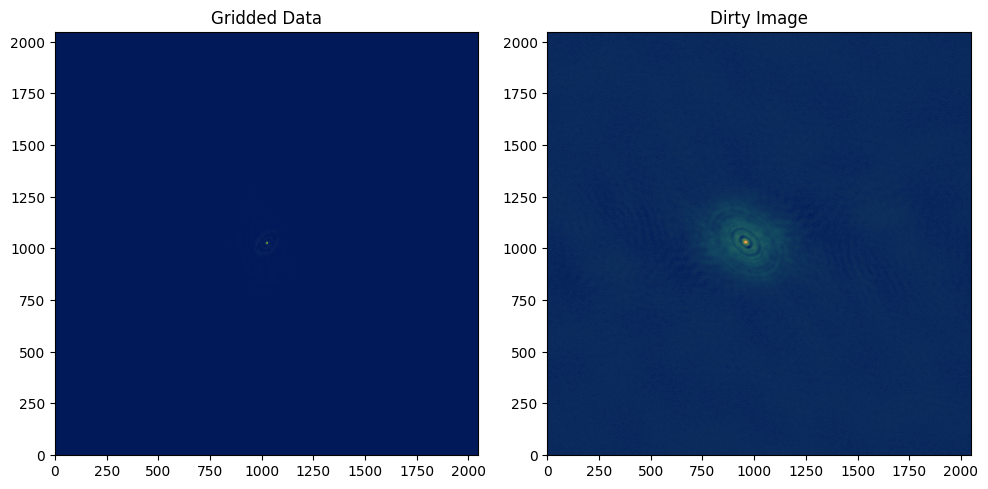

In [20]:
import numpy as np
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

%matplotlib inline
# Cargar el grid desde el archivo
grid = np.load('grid.npy')
# Cargar la imagen sucia desde el archivo
dirty_image = np.load('dirty_image.npy')
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(grid), origin="lower", cmap=cmc.batlow)
ax[0].set_title("Gridded Data")
ax[1].imshow(dirty_image.real, origin="lower", cmap=cmc.batlow)
ax[1].set_title("Dirty Image")
plt.tight_layout()
plt.show()